In [5]:
import matplotlib
import matplotlib.pyplot as plt
from csv import reader
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import pandas as pd
import json
from numpy import sin, cos, arccos, pi, round
from tqdm import tqdm
from geopy import distance

In [8]:
matplotlib.pyplot.rcParams.update({ 
    # 'text.usetex' : True, 
    # 'font.family' : 'STIXGeneral', 
    'font.family' : 'Times New Roman', 
    'font.size': 24
    })

# Readme

## PrepareData

#### Входные значения

#### Представление данных о населении

#### Представление данных о домовладениях

#### Выходные значения

## Assignment

## plotting

# Функции для как бы верификации (надо в 1 обьединить)

In [14]:
def Assignment(SchoolDistance, WorkDistance):
    schoolMark = ['<1']
    nac = 1
    for i in range(int(round(max(SchoolDistance)-1)//3+1)):
        schoolMark.append(f'{nac}-{nac+2}')
        nac+=3

    workMark = ['<1']
    nac = 1
    for i in range(int(round(max(WorkDistance)-1)//3+1)):
        workMark.append(f'{nac}-{nac+2}')
        nac+=3
        
    SchoolAssignment = [[0, i] for i in schoolMark]
    for i in SchoolDistance:
        if int(round(i))<1:
            SchoolAssignment[int(round(i))][0]+=1
        else:
            SchoolAssignment[((int(round(i))-1)//3)+1][0]+=1

    WorkAssignment = [[0, i] for i in workMark]
    for i in WorkDistance:
        if int(round(i))<1:
            WorkAssignment[int(round(i))][0]+=1
        else:
            WorkAssignment[((int(round(i))-1)//3)+1][0]+=1

    return SchoolAssignment, WorkAssignment

In [45]:
def plotting(city_name, workplaceByWorker, householdByResident, SchoolAssignment, WorkAssignment):
    plt.figure(figsize=(12, 12))
    allWP = sum([i[0] for i in workplaceByWorker])
    plt.subplot(2,2,1)
    plt.title("Распределение рабочих мест\n(относительные значения)")
    plt.bar([i[1] for i in workplaceByWorker], [i[0]/allWP for i in workplaceByWorker])
    plt.xlabel("Количество работников")
    plt.ylabel("Доля рабочих мест")
    
    allH = sum([i[0] for i in householdByResident])
    plt.subplot(2,2,2)
    plt.title("Распределение домовладений\n(относительные значения)")
    plt.bar([i[1] for i in householdByResident], [i[0]/allH for i in householdByResident])
    plt.xlabel("Количество жителей")
    plt.ylabel("Доля домовладений")

    return [(i[1],i[0]/allH) for i in householdByResident]
    
    allW = sum([i[0] for i in WorkAssignment])
    plt.subplot(2,2,3)
    plt.title("Расстояние до рабочих мест")
    plt.bar([i[1] for i in WorkAssignment], [i[0]/allW for i in WorkAssignment])
    plt.ylabel("Доля человек")
    plt.xlabel("Расстояние, км.")
    plt.xticks([i for i in range(len(SchoolAssignment)) if i%2==0])

    allS = sum([i[0] for i in SchoolAssignment])
    plt.subplot(2,2,4)
    plt.title("Расстояние до школ")
    plt.bar([i[1] for i in SchoolAssignment], [i[0]/allS for i in SchoolAssignment])
    plt.ylabel("Доля человек")
    plt.xlabel("Расстояние, км.")
    plt.xticks([i for i in range(len(SchoolAssignment)) if i%2==0])
    
    plt.suptitle(f'{city_name}',y=0.93)
    plt.savefig(f"{city_name}.png", dpi=300, bbox_inches='tight')

In [9]:
def PrepareData(city_name, people_path, households_path, school_path, workplace_path):
    data = pd.read_csv(people_path, sep = "\t", index_col=0)
    households = pd.read_csv(households_path, sep = "\t", index_col=0)
    schools = pd.read_csv(school_path, sep = "\t", index_col=0)
    workplaces = pd.read_csv(workplace_path, sep = "\t", index_col=0)

    workersNumber = list(data[(data.work_id!='X')&(data.age>17)].groupby('work_id').size())
    workplaceByWorker = []
    for i in set(workersNumber):
        workplaceByWorker.append([workersNumber.count(i), i])

    residentsNumder = list(data.groupby('sp_hh_id').size())
    householdByResident = []
    for i in set(residentsNumder):
        householdByResident.append([residentsNumder.count(i), i])
    
    pupils = data[(data.age<18)&(data.work_id!='X')]
    pupils.index = [i for i in range(len(pupils))]

    print("Distance to school calculating...")
    SchoolDistance = []
    for i in tqdm(range(len(pupils))):
        person = pupils.iloc[i]
        school = schools[schools.sp_id==int(pupils.iloc[i].work_id)].iloc[0]
        house = households[households.sp_id==int(pupils.iloc[i].sp_hh_id)].iloc[0]
        coordinates_from = [school.longitude, school.latitude][::-1]
        coordinates_to = [house.longitude, house.latitude][::-1]
        SchoolDistance.append(distance.distance(coordinates_from, coordinates_to).km)
    
    
    workers = data[(data.age>17)&(data.work_id!='X')]
    workers.index = [i for i in range(len(workers))]

    print("Distance to work calculating...")    
    WorkDistance = []
    for i in tqdm(range(len(workers))):
        person = workers.iloc[i]
        work = workplaces[workplaces.sp_id==int(workers.iloc[i].work_id)].iloc[0]
        house = households[households.sp_id==int(workers.iloc[i].sp_hh_id)].iloc[0]
        coordinates_from = [work.longitude, work.latitude][::-1]
        coordinates_to = [house.longitude, house.latitude][::-1]
        WorkDistance.append(distance.distance(coordinates_from, coordinates_to).km)

    SchoolAssignment, WorkAssignment = Assignment(SchoolDistance, WorkDistance)
    plotting(city_name, workplaceByWorker, householdByResident, SchoolAssignment, WorkAssignment)
    
    return workplaceByWorker, householdByResident, SchoolAssignment, WorkAssignment


In [37]:
def OnlyWorkHouse(city_name, people_path, households_path):
    data = pd.read_csv(people_path, sep = "\t", index_col=0)
    households = pd.read_csv(households_path, sep = "\t", index_col=0)

    workersNumber = list(data[(data.work_id!='X')&(data.age>17)].groupby('work_id').size())
    workplaceByWorker = []
    for i in set(workersNumber):
        workplaceByWorker.append([workersNumber.count(i), i])

    residentsNumder = list(data.groupby('sp_hh_id').size())
    householdByResident = []
    for i in set(residentsNumder):
        householdByResident.append([residentsNumder.count(i), i])

    SchoolAssignment, WorkAssignment = [], [] #Assignment(SchoolDistance, WorkDistance)
    return plotting(city_name+' only works and houses', workplaceByWorker, householdByResident, SchoolAssignment, WorkAssignment)
    
    #return workplaceByWorker, householdByResident, SchoolAssignment, WorkAssignment


# Самара

In [5]:
# people_path, households_path, school_path, workplace_path
workplaceByWorker1, householdByResident1, SchoolDistance1, WorkDistance1 = PrepareData(
    'Самара',
    './data/samara_15km_new/people_samara_2023_final.txt',
    './data/samara_15km_new/households_samara_2023_final.txt',
    './data/samara_15km_new/schools_samara_2023.txt',
    './data/samara_15km_new/workplaces_samara_splitted.txt'
)

Distance to school calculating...


100%|██████████████████████████████████| 139246/139246 [22:09<00:00, 104.74it/s]


Distance to work calculating...


100%|█████████████████████████████████| 631089/631089 [2:08:55<00:00, 81.58it/s]


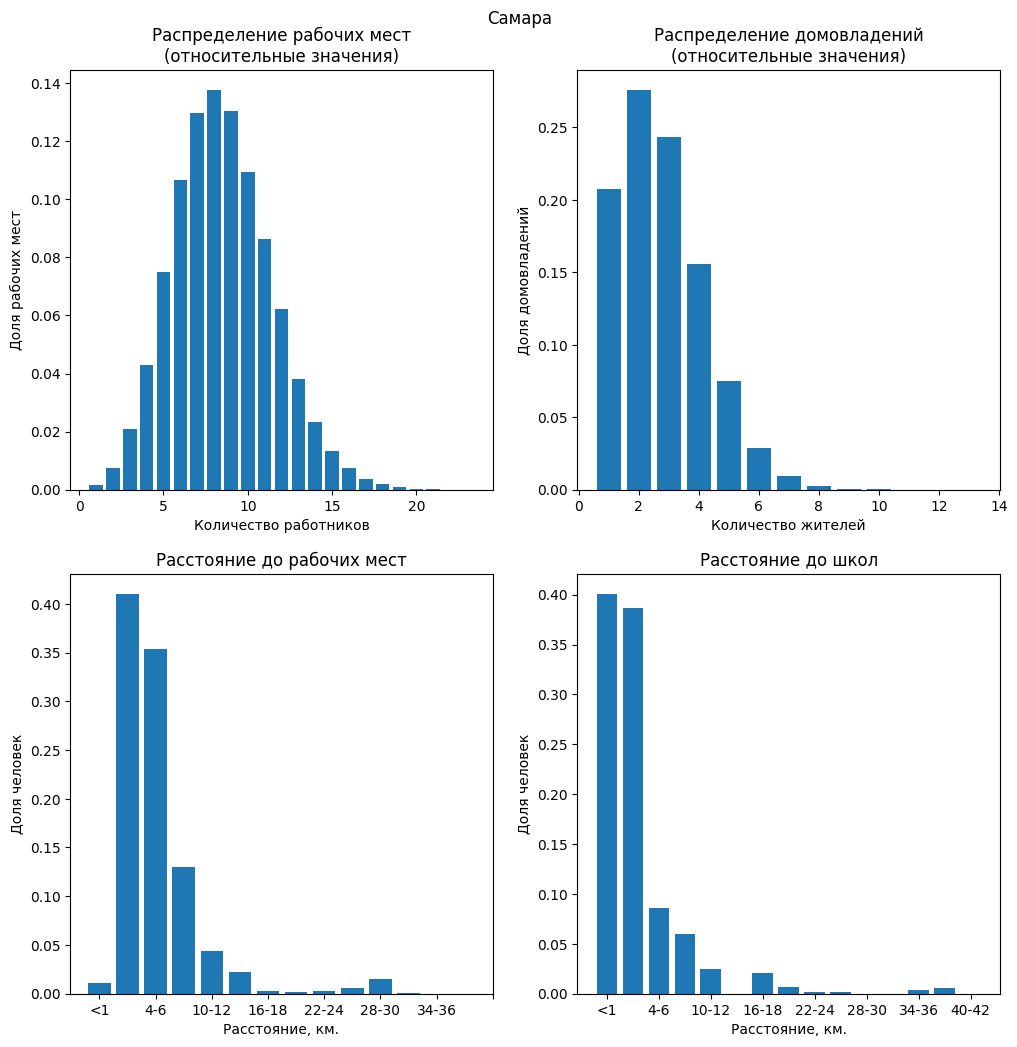

In [12]:
plotting('Самара', workplaceByWorker1, householdByResident1, SchoolDistance1, WorkDistance1)

# Самара тесты

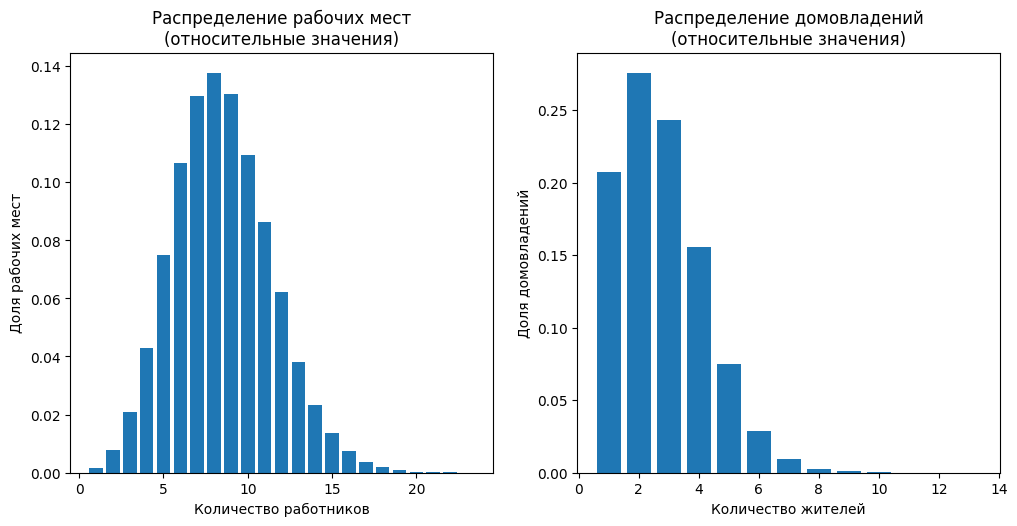

In [46]:
s = OnlyWorkHouse(
    'Самара',
    './data/samara_15km_new/people_samara_2023_final.txt',
    './data/samara_15km_new/households_samara_2023_final.txt'
)

In [47]:
s

[(1, 0.20768983383955691),
 (2, 0.27591686022273837),
 (3, 0.24340896909058424),
 (4, 0.1557453397653505),
 (5, 0.07492585313560836),
 (6, 0.028820201298314575),
 (7, 0.009712345899589065),
 (8, 0.0027514740039306772),
 (9, 0.0007908998868441427),
 (10, 0.0001810493716872134),
 (11, 4.526234292180335e-05),
 (12, 4.76445714966351e-06),
 (13, 7.146685724495265e-06)]

In [49]:
w

[(1, 0.08613738639802423),
 (2, 0.21407444285003074),
 (3, 0.2695014691383333),
 (4, 0.21816460206362687),
 (5, 0.12705850196698587),
 (6, 0.0551829833757968),
 (7, 0.020948643609492293),
 (8, 0.00635487744164934),
 (9, 0.0019328198670454213),
 (10, 0.00048808582501147003),
 (11, 0.0001171405980027528),
 (12, 9.7617165002294e-06),
 (13, 2.92851495006882e-05)]

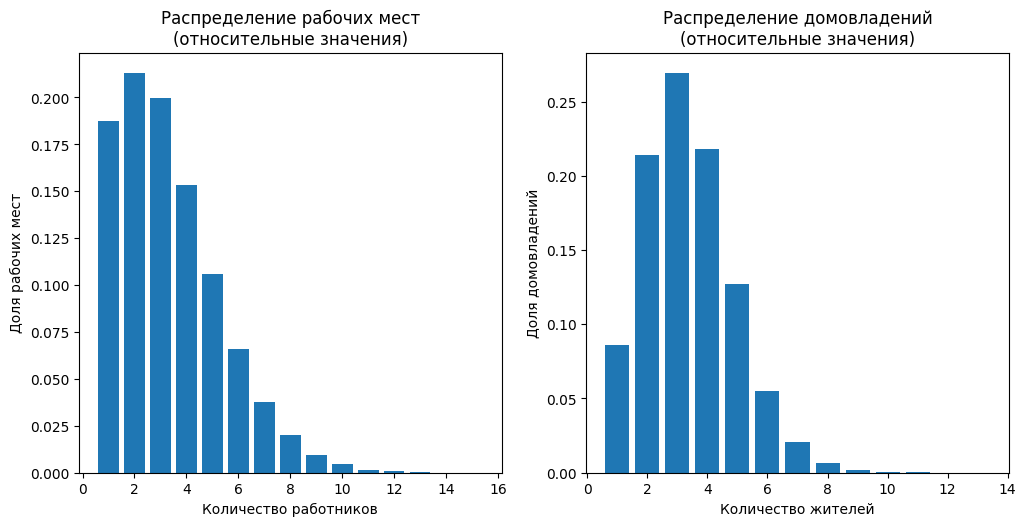

In [48]:
# people_path, households_path, school_path, workplace_path
w = OnlyWorkHouse(
    'Самара 10%',
    './data/samara_10_test_1/people_sampled.txt',
    './data/samara_10_test_1/households_sampled.txt',
)

In [52]:
w

[(1, 0.20864803107945454),
 (2, 0.3252486841189974),
 (3, 0.26177442100181914),
 (4, 0.12854845203489904),
 (5, 0.05364915882688971),
 (6, 0.018573051684559555),
 (7, 0.002811990800953632),
 (8, 0.00032883850445934525),
 (9, 0.0003225146870658963),
 (10, 9.485726090173421e-05)]

In [54]:
w

[(1, 0.2088190038572603),
 (2, 0.327234787007567),
 (3, 0.2605231541007103),
 (4, 0.12776384292730222),
 (5, 0.053927871340345254),
 (6, 0.018253483127120967),
 (7, 0.0029614484750121197),
 (8, 0.0003267078388803406),
 (9, 0.00013700651307885253),
 (10, 5.269481272263558e-05)]

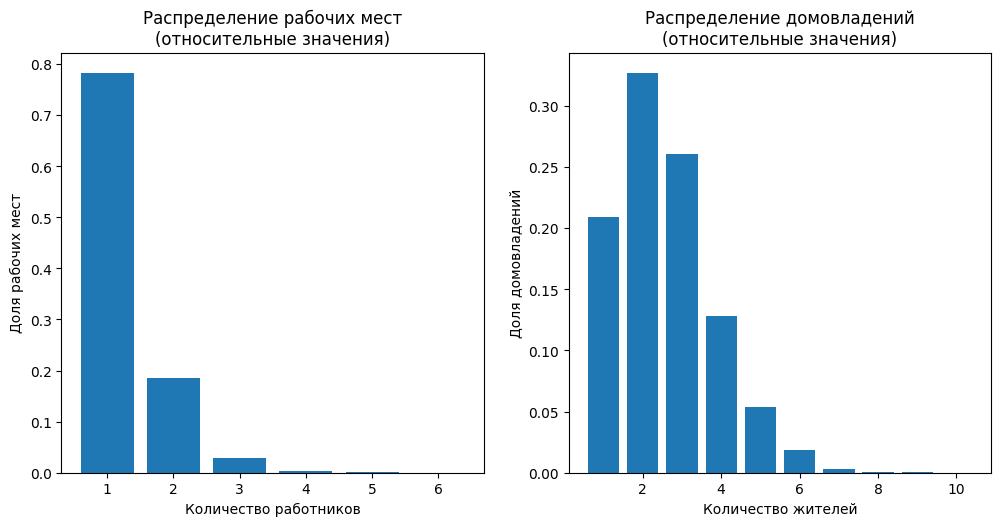

In [53]:
w = OnlyWorkHouse(
    'Питер',
    './data/sampling_5/people_sampled.txt',
    './data/sampling_5/households_sampled.txt',
)

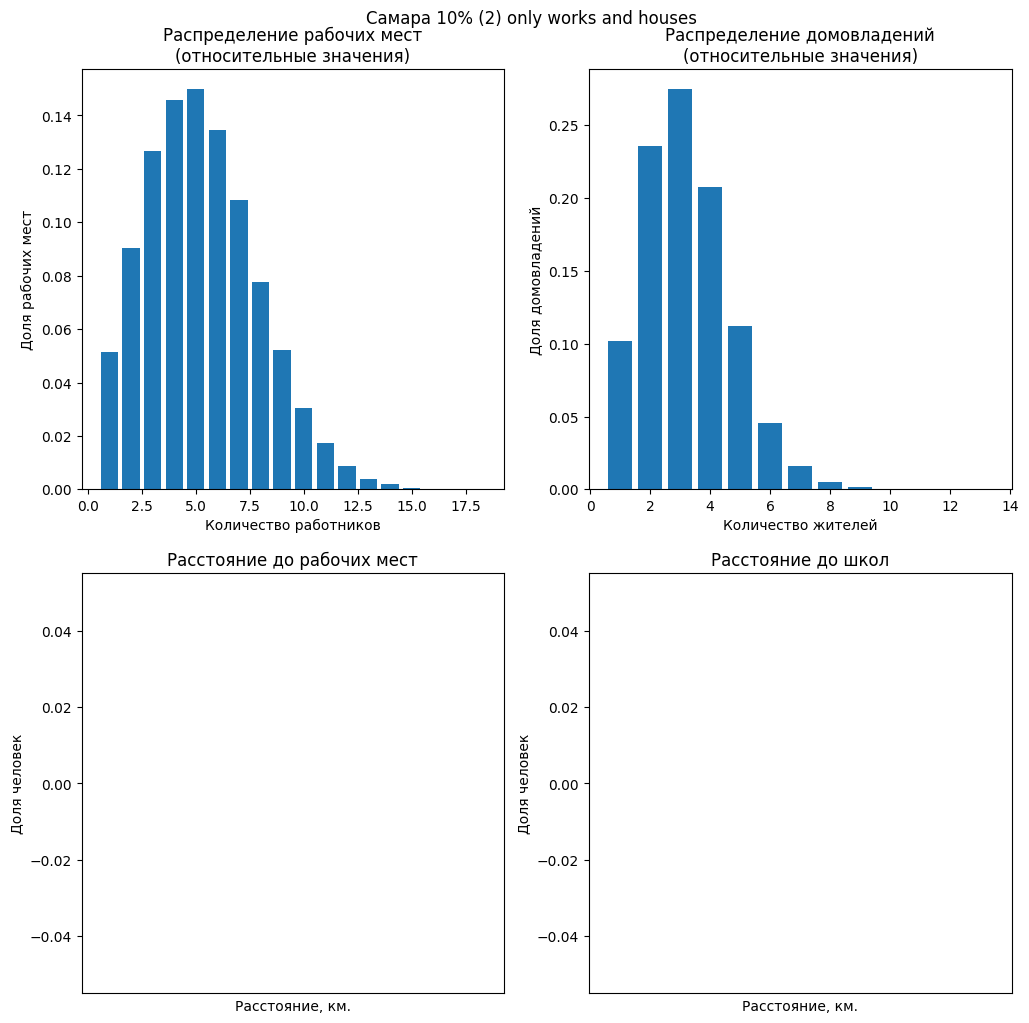

In [23]:
# people_path, households_path, school_path, workplace_path
OnlyWorkHouse(
    'Самара 10% (2)',
    './data/samara_10_test_2/people_sampled.txt',
    './data/samara_10_test_2/households_sampled.txt',
)

# Самара 10%

In [13]:
# people_path, households_path, school_path, workplace_path
workplaceByWorker2, householdByResident2, SchoolDistance2, WorkDistance2 = PrepareData(
    'Самара 10%',
    './data/samara_10/people_sampled.txt',
    './data/samara_10/households_sampled.txt',
    './data/samara_10/schools_samara_2023.txt',
    './data/samara_10/workplaces_samara_splitted.txt'
)

Distance to school calculating...


100%|████████████████████████████████████| 41714/41714 [03:26<00:00, 201.80it/s]


Distance to work calculating...


100%|██████████████████████████████████| 188957/188957 [23:36<00:00, 133.38it/s]


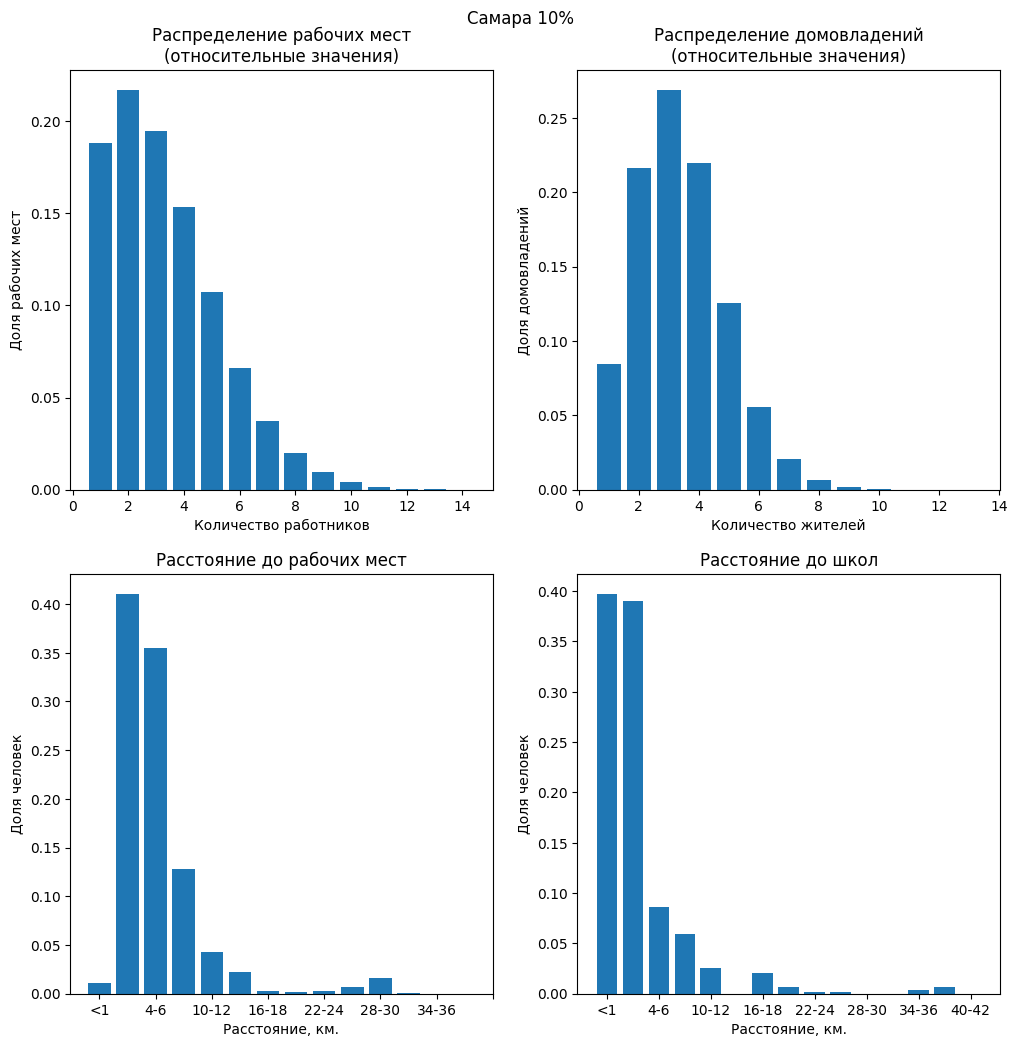

In [14]:
plotting('Самара 10%', workplaceByWorker2, householdByResident2, SchoolDistance2, WorkDistance2)

# Самара 25%

In [8]:
# people_path, households_path, school_path, workplace_path
#workplaceByWorker, householdByResident, SchoolDistance, WorkDistance = PrepareData(
#    'Самара 25%',
#    './data/samara_25/people_sampled.txt',
#    './data/samara_25/households_sampled.txt',
#    './data/samara_25/schools_samara_2023.txt',
#    './data/samara_25/workplaces_samara_splitted.txt'
#)

In [ ]:
#plotting('Самара 25%', workplaceByWorker2, householdByResident2, SchoolDistance2, WorkDistance2)

# Челябинск

In [37]:
# people_path, households_path, school_path, workplace_path
workplaceByWorker, householdByResident, SchoolDistance, WorkDistance = PrepareData(
    'Челябинск',
    './chelyabinsk_15km/people_chelyabinsk_2023_final.txt',
    './chelyabinsk_15km/households_chelyabinsk_2023_final.txt',
    './chelyabinsk_15km/schools_chelyabinsk_2023.txt',
    './chelyabinsk_15km/workplaces_chelyabinsk_splitted.txt')

Distance to school calculating...


100%|██████████████████████████████████| 163886/163886 [16:40<00:00, 163.76it/s]


Distance to work calculating...


100%|████████████████████████████████| 637555/637555 [1:23:21<00:00, 127.48it/s]


# Челябинск 10%

In [27]:
# people_path, households_path, school_path, workplace_path
workplaceByWorker, householdByResident, SchoolDistance, WorkDistance = PrepareData(
    'Челябинск 10%',
    './data/chelyabinsk_10/people_sampled.txt',
    './data/chelyabinsk_10/households_sampled.txt',
    './data/chelyabinsk_10/schools_chelyabinsk_2023.txt',
    './data/chelyabinsk_10/workplaces_chelyabinsk_splitted.txt')

Distance to school calculating...


100%|████████████████████████████████████| 49193/49193 [01:19<00:00, 615.92it/s]


Distance to work calculating...


100%|██████████████████████████████████| 190365/190365 [09:22<00:00, 338.53it/s]


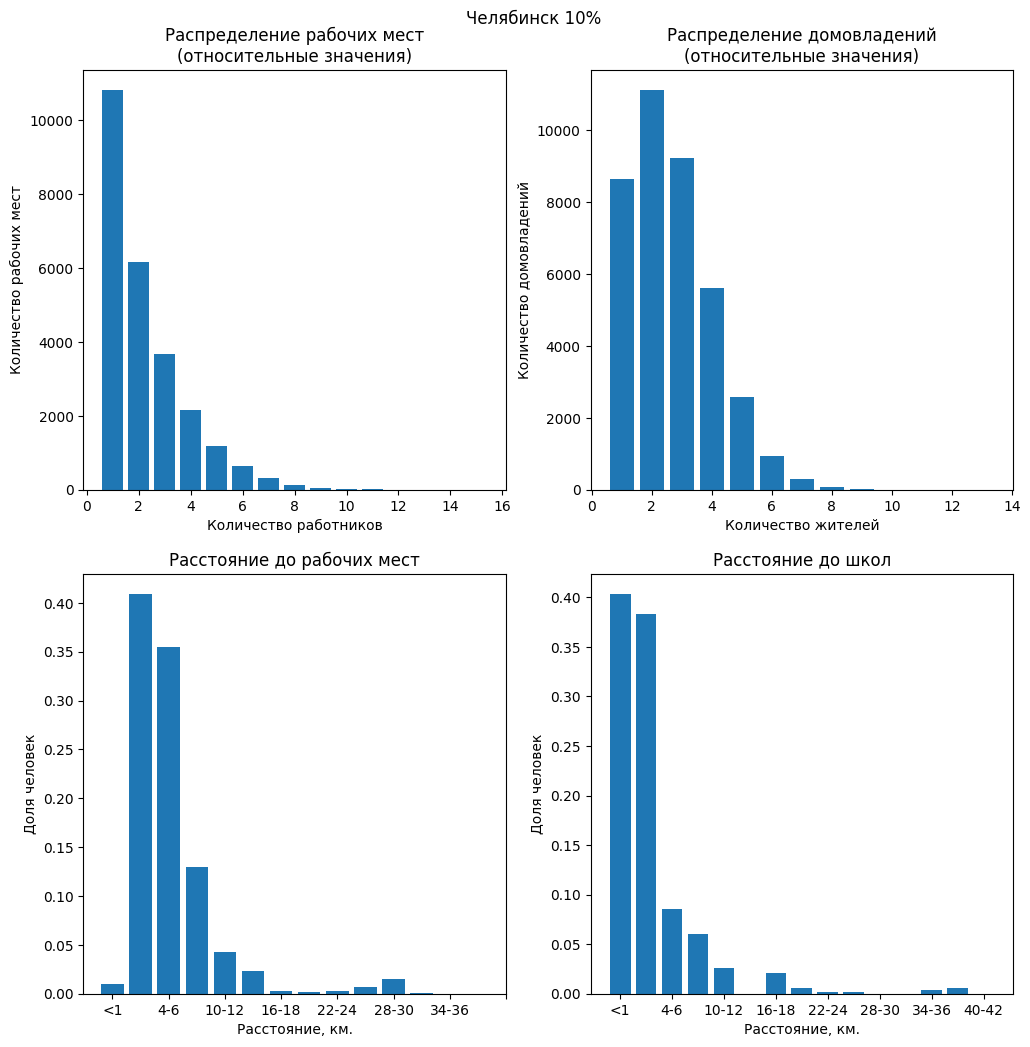

In [34]:
plotting('Челябинск 10%', workplaceByWorker2, householdByResident2, SchoolDistance2, WorkDistance2)

# Челябинск 25%

In [36]:
# people_path, households_path, school_path, workplace_path
workplaceByWorker3, householdByResident3, SchoolDistance3, WorkDistance3 = PrepareData(
    'Челябинск 25%',
    './data/chelyabinsk_25/people_sampled.txt',
    './data/chelyabinsk_25/households_sampled.txt',
    './data/chelyabinsk_25/schools_chelyabinsk_2023.txt',
    './data/chelyabinsk_25/workplaces_chelyabinsk_splitted.txt')

Distance to school calculating...


100%|████████████████████████████████████| 98190/98190 [02:43<00:00, 598.75it/s]


Distance to work calculating...


100%|██████████████████████████████████| 381319/381319 [16:47<00:00, 378.35it/s]


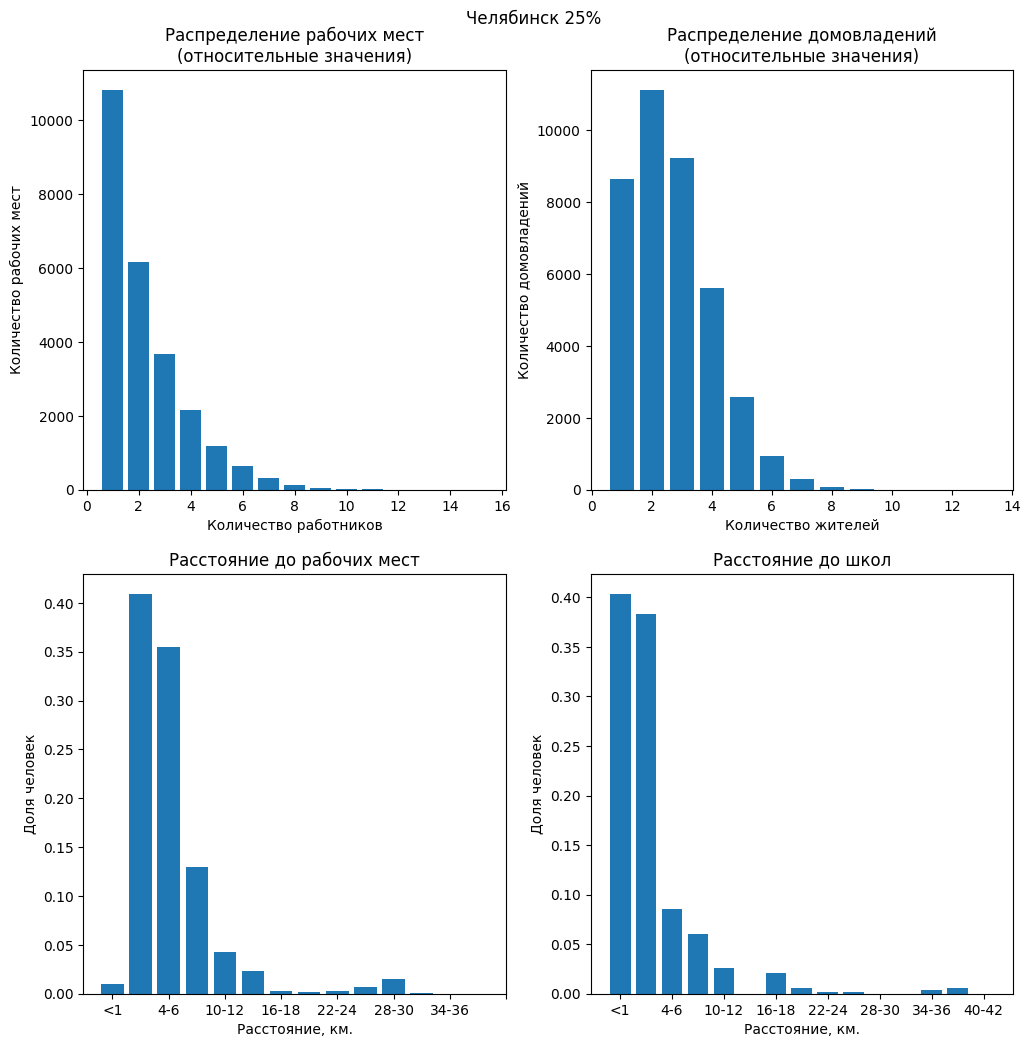

In [37]:
plotting('Челябинск 25%', workplaceByWorker2, householdByResident2, SchoolDistance2, WorkDistance2)

# Построение графика (Upd: неактуально, сохранил, чтобы был пример выходного значения)

In [38]:
#SchoolAssignment, WorkAssignment = Assignment(SchoolDistance, WorkDistance)

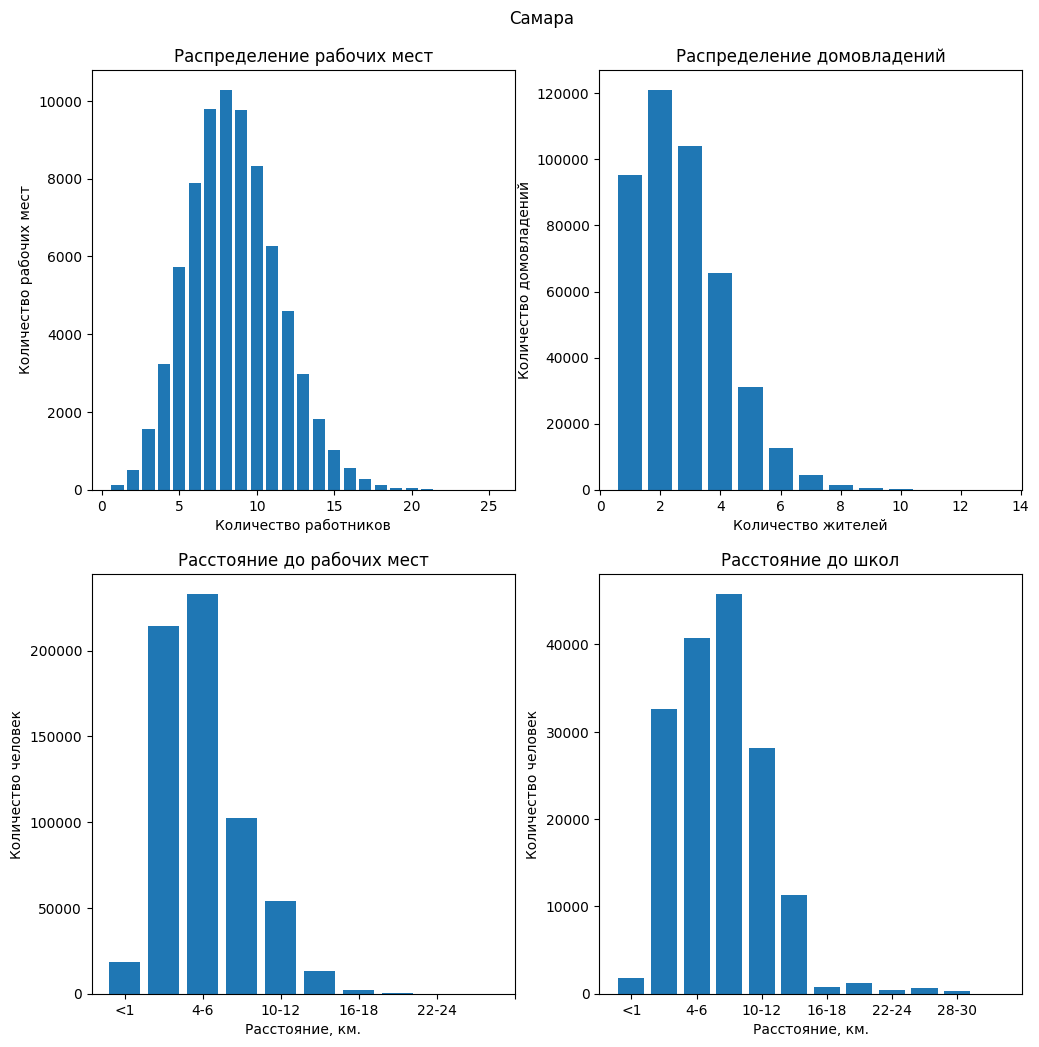

In [39]:
# Нужно менять название города
#plotting("X", workplaceByWorker, householdByResident, SchoolAssignment, WorkAssignment)

# Построение карты (надо дописать как пользоваться и структуру общую файла продумать, но функция работающая)

In [18]:
def Map_Pop(city, rosstat_dic, geojson, people_path, households_path, key_value):
    geo_df_s = gpd.read_file(geojson)
    data = pd.read_csv(people_path, sep = "\t", index_col=0)
    households = pd.read_csv(households_path, sep = "\t")

    data_hh_occurency = data.groupby(['sp_hh_id']).size()
    latitudes = households['latitude'].to_numpy() 
    longitudes = households['longitude'].to_numpy() 
    sp_id = households['sp_id'].to_numpy() 
     
    hh_coords = {sp:Point((lon, lat))for lat, lon, sp in zip(latitudes, longitudes, sp_id)}

    key = []
    population_MO = [] 
    print("Определение населения в МО")
    for index_MO in tqdm(range(len(geo_df_s))): 
        population_MO_counter = 0 
        polygon = geo_df_s.iloc[index_MO]['geometry']
        key.append( geo_df_s.iloc[index_MO][key_value])
        for index_hh in data_hh_occurency.index: 
            population_MO_counter+=(polygon.contains(hh_coords[index_hh]) * data_hh_occurency.loc[index_hh])
    
        population_MO.append(population_MO_counter) 
    
    # просчитанная популяция по МО
    mo_pop_dic = {ind: i for ind, i in zip(key, population_MO)}

    geo_df_s['population'] = pd.Series([rosstat_dic[i]/mo_pop_dic[i] for i in geo_df_s[key_value]])
    geo_df_s['sint'] = pd.Series([mo_pop_dic[i] for i in geo_df_s[key_value]])
    geo_df_s['ofic'] = pd.Series([rosstat_dic[i] for i in geo_df_s[key_value]])
    return geo_df_s
    right_p = []
    left_p = []
    for i,j in zip(geo_df_s['sint'], geo_df_s['ofic']):
        if j>i:
            right_p.append(round((j/i)*100-100))
        else:
            left_p.append(round((i/j)*100-100))
    left_p, right_p = set(left_p), set(right_p)

    
    vmax=1+max(max(left_p if len(left_p)!=0 else [0]), max(right_p if len(right_p)!=0 else [0]))/100
    vmin=1-max(max(left_p if len(left_p)!=0 else [0]), max(right_p if len(right_p)!=0 else [0]))/100
    fig, ax = plt.subplots(figsize=(9, 9)) 
    geo_df_s.plot(ax=ax, 
                  column='population', 
                  legend=True, 
                  cmap='bwr', 
                  edgecolor="black", 
                  vmin=vmin, 
                  vmax=vmax, 
                  legend_kwds={
                      "pad": 0,
                      "orientation": "horizontal"
                  }).set_title(f"Отношение расчётных численностей населения районов\nсогласно значениям переписи населения по г.{city}\nк аналогичным значениям синтетической популяции")
    ax.axis("off")
    #ax.text(60.93, 54.91, "synth. pop. size / oficial data population size")
    #ax.text(61.4, 54.91, "oficial data population size / synth. pop. size")
    
    colourbar = ax.get_figure().get_axes()[1] 
    yticks = colourbar.get_xticks()
    
    yticks = list(yticks)
    _1 = list(yticks).index(1)
    
    for i in range(_1):
        if len(right_p)>=len(left_p):
            yticks[i] = f'-{round(yticks[-(i+1)]*100-100, 2)}%'
        else:
            yticks[i] = f'-{round(yticks[i]*100-100, 2)}%'
    yticks[_1] = '0%'
    for i in range(_1+1, len(yticks)):
        if len(right_p)>=len(left_p):
            yticks[i] = f'+{round(yticks[i]*100-100, 2)}%'
        else:
            yticks[i] = f'+{round(yticks[len(yticks)-1-i]*100-100, 2)}%'
    colourbar.set_xticklabels(yticks)
    fig.savefig(f"{city}.png", dpi=300, bbox_inches='tight')

    return geo_df_s

In [19]:
def plot(geo_df_s, city):
    geo_df_s.crs
    geo_df_s = geo_df_s.to_crs(epsg=3857)
    right_p = [5]  # 5 - Samara
    left_p = []
    for i,j in zip(geo_df_s['sint'], geo_df_s['ofic']):
        if j>i:
            right_p.append(round((j/i)*100-100))
        else:
            left_p.append(round((i/j)*100-100))
    left_p, right_p = set(left_p), set(right_p)

    
    vmax=1+max(max(left_p if len(left_p)!=0 else [0]), max(right_p if len(right_p)!=0 else [0]))/100
    vmin=1-max(max(left_p if len(left_p)!=0 else [0]), max(right_p if len(right_p)!=0 else [0]))/100
    fig, ax = plt.subplots(figsize=(9, 9)) 
    geo_df_s.plot(ax=ax, 
                  alpha=0.85,
                  column='population', 
                  legend=True, 
                  cmap=newcmp, 
                  edgecolor="black", 
                  vmin=vmin, 
                  vmax=vmax, 
                  legend_kwds={
                      "pad": 0.05,  "shrink":.9
                  })
    cx.add_basemap(ax)
    ax.axis("off")
    #ax.text(60.93, 54.91, "synth. pop. size / oficial data population size")
    #ax.text(61.4, 54.91, "oficial data population size / synth. pop. size")
    
    colourbar = ax.get_figure().get_axes()[1] 
    yticks = colourbar.get_yticks()
    
    yticks = list(yticks)
    _1 = list(yticks).index(1)
    
    for i in range(_1):
        #if len(right_p)>=len(left_p):
        #    yticks[i] = f'− {round(yticks[-(i+1)]*100-100, 2)}%'
        #else:
        yticks[i] = f'− {abs(round(yticks[i]*100-100, 2))}%'
    yticks[_1] = '  0%'
    print(yticks, _1)
    for i in range(_1+1, len(yticks)):
        #if len(right_p)>=len(left_p):
        yticks[i] = f'+ {abs(round(yticks[i]*100-100, 2))}%'
        #else:
        #yticks[i] = f'+ {round(yticks[len(yticks)-1-i]*100-100, 2)}%'
    colourbar.set_yticklabels(yticks)
    cx.add_basemap(ax)
    fig.savefig(f"{city}.png", dpi=300, bbox_inches='tight')


# Самара

In [20]:
# словарь - определитель: количество_людей_в_МО 
d = {
    'Красноглинский район': 104252,
    'Куйбышевский район': 97367,
    'Самарский район': 30989,
    'Ленинский район': 61542,
    'Железнодорожный район': 90133,
    'Октябрьский район': 134393,
    'Советский район': 166867,
    'Промышленный район': 268899,
    'Кировский район': 218857
}

In [21]:
geo_df_s = Map_Pop(
    "Самара",
    d,
    "самара.районы", 
    './samara_15km_new/people_samara_2023_final.txt',
    './samara_15km_new/households_samara_2023_final.txt',
    'name')

DriverError: самара.районы: No such file or directory

In [22]:
plot(geo_df_s,  "Самара")

NameError: name 'geo_df_s' is not defined

# Челябинск

In [ ]:
# словарь - определитель: количество_людей_в_МО 
d = {
    'Leninskiy rayon': 187977,
    'Тракторозаводский район': 178520,
    'Sovetskiy rayon': 134541,
    'Металлургический район': 128506,
    'Центральный район': 101285,
    'Калининский район': 228656,
    'Kurchatovskiy rayon': 223032
}

In [ ]:
geo_df_s = Map_Pop(
    "Челябинск",
    d,
    "самара.районы", 
    './chelyabinsk_15km/people_chelyabinsk_2023_final.txt',
    './chelyabinsk_15km/households_chelyabinsk_2023_final.txt',
    'name')

In [ ]:
plot(geo_df_s,  "Челябинск")